In [2]:
import pandas as pd

def process(file):
    df = pd.read_csv(file)
    df.insert(0, '序号', range(len(df)))
    df.to_csv(file, index=False)
    
if __name__ == '__main__':
    files = ['/home/tiantianyi/code/public-sentiment-analysis/data/processed/train.csv', '/home/tiantianyi/code/public-sentiment-analysis/data/processed/test.csv']
    for file in files:
        process(file)
        print(f'{file} processed.')

/home/tiantianyi/code/public-sentiment-analysis/data/processed/train.csv processed.
/home/tiantianyi/code/public-sentiment-analysis/data/processed/test.csv processed.


In [5]:
import pandas as pd

# 读取原始数据
input_file = "/home/tiantianyi/code/public-sentiment-analysis/data/processed/train.csv"
df = pd.read_csv(input_file)

# 拼接 text 和 target
df['text'] = df['text'] + " [SEP] target: " + df['target']

# 保存到新的 CSV 文件
output_file = "/home/tiantianyi/code/public-sentiment-analysis/data/test/train.csv"
df.to_csv(output_file, index=False)

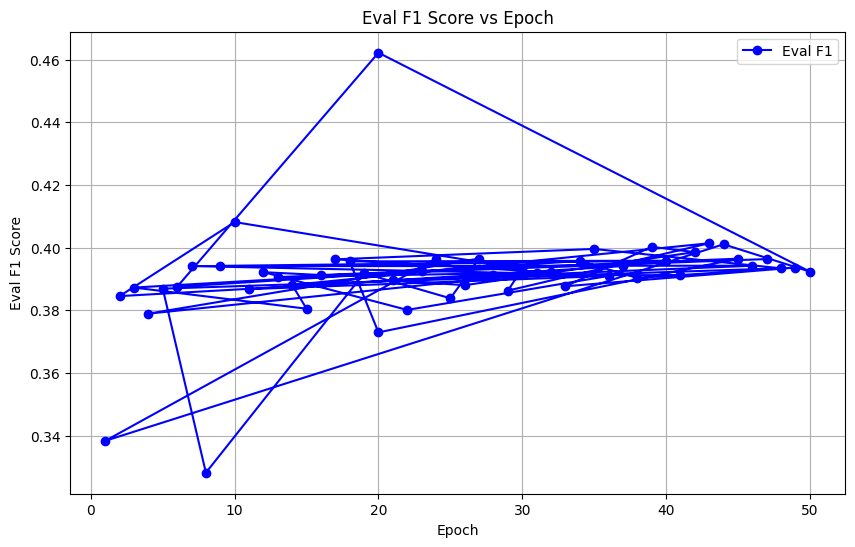

In [9]:
%matplotlib inline
import os
import json
import matplotlib.pyplot as plt

def plot_eval_f1_vs_epoch(base_dir: str):
    epochs = []
    eval_f1_scores = []

    # 遍历 base_dir 下的所有子目录
    for subdir in [os.path.join(base_dir, d) for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]:
        trainer_state_path = os.path.join(subdir, "trainer_state.json")
        
        # 检查 trainer_state.json 是否存在
        if not os.path.exists(trainer_state_path):
            print(f"文件 {trainer_state_path} 不存在，跳过。")
            continue

        try:
            # 读取 trainer_state.json 文件
            with open(trainer_state_path, "r", encoding="utf-8") as f:
                trainer_state = json.load(f)
            
            # 提取 log_history 列表的最后一个元素
            log_history = trainer_state.get("log_history", [])
            if not log_history:
                print(f"文件 {trainer_state_path} 的 log_history 为空，跳过。")
                continue
            
            last_log = log_history[-1]  # 获取最后一个元素
            eval_f1 = last_log.get("eval_f1")
            epoch = last_log.get("epoch")

            # 确保 eval_f1 和 epoch 存在
            if eval_f1 is not None and epoch is not None:
                eval_f1_scores.append(eval_f1)
                epochs.append(epoch)
        except (json.JSONDecodeError, KeyError) as e:
            print(f"解析 {trainer_state_path} 时出错: {e}")
            continue

    # 绘制折线图
    if epochs and eval_f1_scores:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, eval_f1_scores, marker="o", linestyle="-", color="b", label="Eval F1")
        plt.xlabel("Epoch")
        plt.ylabel("Eval F1 Score")
        plt.title("Eval F1 Score vs Epoch")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("没有足够的数据绘制图表。")

plot_eval_f1_vs_epoch("/home/tiantianyi/code/public-sentiment-analysis/models/output")

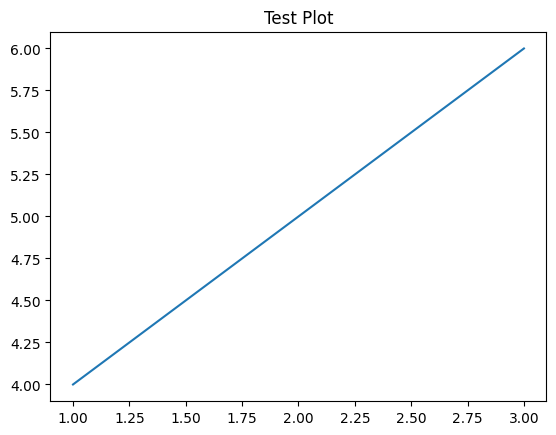

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot([1, 2, 3], [4, 5, 6])
plt.title("Test Plot")
plt.show()

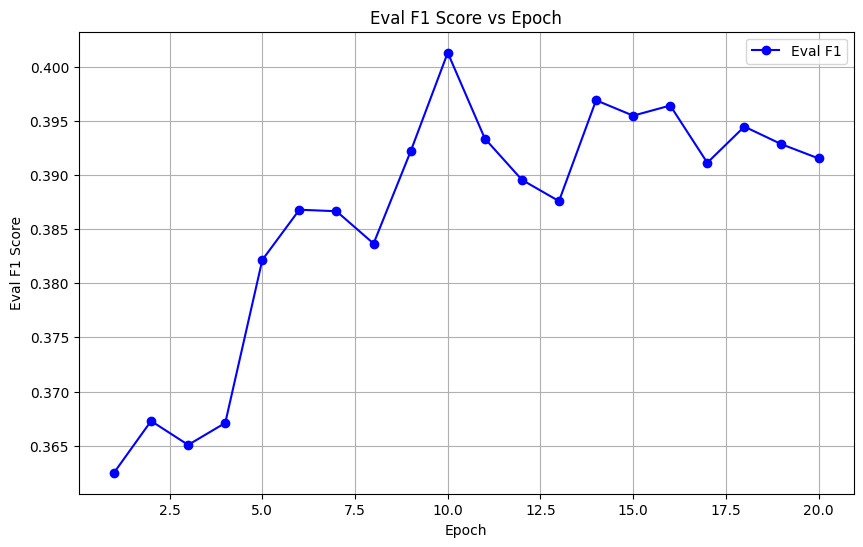

In [1]:
import json
import matplotlib.pyplot as plt

def plot_eval_f1_vs_epoch(train_state: str):
    with open(train_state, "r") as f:
        data = json.load(f)

    log_history = data.get("log_history", [])
    if not log_history:
        print("log_history 为空。")
        return
    
    epochs, eval_f1 = zip(*map(lambda x: (x["epoch"], x["eval_f1"]), filter(lambda x: "eval_f1" in x, log_history)))

    if epochs and eval_f1:
        plt.figure(figsize=(10, 6))
        plt.plot(epochs, eval_f1, marker="o", linestyle="-", color="b", label="Eval F1")
        plt.xlabel("Epoch")
        plt.ylabel("Eval F1 Score")
        plt.title("Eval F1 Score vs Epoch")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("没有足够的数据绘制图表。")

plot_eval_f1_vs_epoch("/home/tiantianyi/code/public-sentiment-analysis/models/output/checkpoint-2120/trainer_state.json")

In [17]:
DATASET_INCREASE_ROUND = 10
for i in range(DATASET_INCREASE_ROUND
               ):
    data_ratio = [i * 1 / DATASET_INCREASE_ROUND, (i + 1) * 1 / DATASET_INCREASE_ROUND]
    print(data_ratio)

[0.0, 0.1]
[0.1, 0.2]
[0.2, 0.3]
[0.3, 0.4]
[0.4, 0.5]
[0.5, 0.6]
[0.6, 0.7]
[0.7, 0.8]
[0.8, 0.9]
[0.9, 1.0]


In [18]:
import os
import pandas as pd

def process_csv_files(input_dir: str):
    """
    修改指定目录下所有 CSV 文件的列名和数据。

    Args:
        input_dir (str): 包含 CSV 文件的目录路径。

    Returns:
        None
    """
    # 遍历目录下的所有文件
    for file_name in os.listdir(input_dir):
        file_path = os.path.join(input_dir, file_name)

        # 检查是否为 CSV 文件
        if not file_name.endswith(".csv"):
            print(f"跳过非 CSV 文件: {file_name}")
            continue

        try:
            # 读取 CSV 文件
            df = pd.read_csv(file_path)

            # 检查所需列是否存在
            required_columns = ["Text", "Target 1", "Stance 1"]
            if not all(col in df.columns for col in required_columns):
                print(f"文件 {file_name} 缺少必要的列，跳过处理。")
                continue

            # 修改列名
            df.rename(
                columns={
                    "Text": "text",
                    "Target 1": "target",
                    "Stance 1": "label"
                },
                inplace=True
            )

            # 映射 Stance 1 的值
            stance_mapping = {"FAVOR": 1, "AGAINST": 0, "NONE": 2}
            df["label"] = df["label"].map(stance_mapping)

            # 保存修改后的文件
            output_file_path = os.path.join(input_dir, f"processed_{file_name}")
            df.to_csv(output_file_path, index=False)
            print(f"文件 {file_name} 已成功处理并保存为 {output_file_path}")

        except Exception as e:
            print(f"处理文件 {file_name} 时出错: {e}")

# 调用函数
process_csv_files("/home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE")

文件 train.csv 已成功处理并保存为 /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE/processed_train.csv
文件 test.csv 已成功处理并保存为 /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE/processed_test.csv
文件 val.csv 已成功处理并保存为 /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE/processed_val.csv


In [19]:
import os
import pandas as pd

def modify_csv_files(directory):
    """
    修改指定目录中的所有 CSV 文件：
    1. 修改列名：Text -> text, Target 1 -> target, Stance 1 -> label, Type 保持不变。
    2. 修改 Stance 1 列的值：支持 -> 1，反对 -> 0，中立 -> 2。
    
    :param directory: 包含 CSV 文件的目录路径
    """
    # 遍历目录中的所有文件
    for filename in os.listdir(directory):
        # 检查文件是否为 CSV 文件
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            
            # 读取 CSV 文件
            df = pd.read_csv(file_path)
            
            # 修改列名
            column_mapping = {
                "Text": "text",
                "Target 1": "target",
                "Stance 1": "label"
            }
            df.rename(columns=column_mapping, inplace=True)
            
            # 修改 label 列的值
            if "label" in df.columns:
                stance_mapping = {
                    "支持": 1,
                    "反对": 0,
                    "中立": 2
                }
                df["label"] = df["label"].map(stance_mapping)
            
            # 保存修改后的文件
            df.to_csv(file_path, index=False)
            print(f"Modified and saved: {file_path}")

# 使用函数
directory_path = "/home/tiantianyi/code/public-sentiment-analysis/data/csv_data/C-Stance"
modify_csv_files(directory_path)

Modified and saved: /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/C-Stance/train.csv
Modified and saved: /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/C-Stance/test.csv
Modified and saved: /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/C-Stance/raw_val_all_onecol.csv


In [20]:
import os
import pandas as pd

def remove_columns_from_csv(directory):
    """
    删除指定目录中所有 CSV 文件的 'Keywords', 'seen?', 'Ori Text' 列。

    Args:
        directory (str): 包含 CSV 文件的目录路径。
    """
    # 遍历目录中的所有文件
    for filename in os.listdir(directory):
        # 检查文件是否为 CSV 文件
        if filename.endswith(".csv"):
            file_path = os.path.join(directory, filename)
            
            try:
                # 读取 CSV 文件
                df = pd.read_csv(file_path)
                
                # 删除指定列
                columns_to_remove = ["Keywords", "seen?", "Ori Text"]
                df.drop(columns=[col for col in columns_to_remove if col in df.columns], inplace=True)
                
                # 保存修改后的文件
                df.to_csv(file_path, index=False)
                print(f"已处理文件: {file_path}")
            
            except Exception as e:
                print(f"处理文件 {file_path} 时出错: {e}")

# 调用函数
directory_path = "/home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE"
remove_columns_from_csv(directory_path)

已处理文件: /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE/train.csv
已处理文件: /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE/test.csv
已处理文件: /home/tiantianyi/code/public-sentiment-analysis/data/csv_data/EZ-STANCE/val.csv
